In [1]:
import numpy as np

import deepxde as dde

from project.gen_data import gen_data
from project.post_processing import plot_2d_y, plot_2d

Using backend: tensorflow.compat.v1

2021-12-08 10:37:09.694274: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term







In this code we will solve the heat equation using PINN implemented with the DeepXDE library.

The equation is as follows:

$\frac{\partial u}{\partial t} = \alpha \nabla^2 u\;$ .

Where $\nabla^2$ is the laplacian differential operator, $\alpha$ is the thermal diffusivity constant and $u$ is the function (temperature) we want to approximate.

In a unidimensional case we have:

$\frac{\partial u(x, t)}{\partial t}$ = $\alpha \frac{\partial^2u(x,t)}{{\partial x}^2}\;$, $\;\;\;\; x \in [0, 1]\;$, $\;\;\;\; t \in [0, 1]\;$.

With Dirichlet boundary conditions 

$u(0, t) = u(1, t) = 0\;$ , 

and periodic (sinoidal) initial conditions:

$u(x, 0) = sin(n\pi x/L)\;$, $\;\;\;\; 0 < x < L\;$, $\;\;\;\; n = 1, 2, ...\;.$

This setup is a common problem in many differential equations textbooks and can be physically interpreted as the variation of temperature in a uniform and unidimensional bar over time. Here, the constant $\alpha$ is the thermal diffusivity (a property of the material that the bar is made) and $L$ is the lenght of the bar.



In [8]:
# Problem parameters:
a = 0.4 # Thermal diffusivity
L = 1 # Length of the bar
n = 1 # Frequency of the sinusoidal initial conditions

def pde(x, y):
    """
    Expresses the PDE residual of the heat equation.        
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a*dy_xx

# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(
    geomtime, lambda x: np.sin(n*np.pi*x[:, 0:1]/L) , lambda _, on_initial: on_initial
    )

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=200, num_boundary=10, num_initial=10, num_test=500
)

# original
# net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(epochs=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

here2
Compiling model...
Building feed-forward neural network...
'build' took 0.031094 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+202=202. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+12=12. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/ba

'compile' took 0.214038 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.19e-02, 3.79e-02, 2.75e-01]    [2.16e-02, 3.79e-02, 2.75e-01]    []  
1000      [5.08e-04, 5.77e-05, 1.35e-04]    [4.09e-04, 5.77e-05, 1.35e-04]    []  
2000      [6.49e-05, 1.08e-05, 1.96e-05]    [7.46e-05, 1.08e-05, 1.96e-05]    []  
3000      [2.92e-05, 5.43e-06, 1.09e-05]    [3.68e-05, 5.43e-06, 1.09e-05]    []  
4000      [1.89e-05, 2.86e-06, 5.98e-06]    [2.39e-05, 2.86e-06, 5.98e-06]    []  
5000      [1.45e-05, 2.35e-06, 4.50e-06]    [1.83e-05, 2.35e-06, 4.50e-06]    []  
6000      [1.19e-05, 2.14e-06, 3.70e-06]    [1.53e-05, 2.14e-06, 3.70e-06]    []  
7000      [1.03e-05, 2.03e-06, 3.18e-06]    [1.34e-05, 2.03e-06, 3.18e-06]    []  
8000      [9.02e-06, 1.95e-06, 2.75e-06]    [1.19e-05, 1.95e-06, 2.75e-06]    []  
9000      [1.13e-05, 1.35e-05, 2.32e-05]    [1.31e-05, 1.35e-05, 2.32e-05]    []  
10000   

bc_points shape (20, 2)
train_next_batch shape (240, 2)


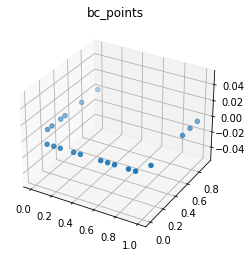

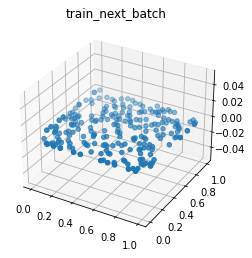

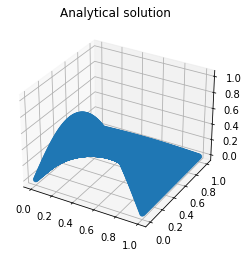

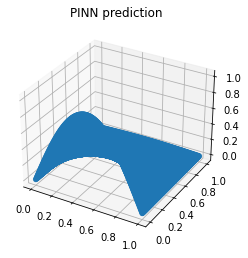

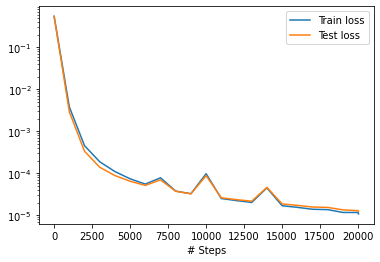

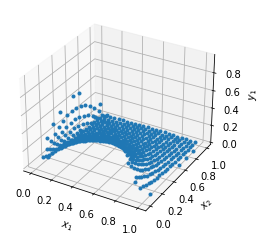

Mean residual: 0.002666849
L2 relative error: 0.003347006894662124


In [7]:
X_test, y_true = gen_data(
    "heat_1d_boundary_sin_exact",
    {
        "x_range": (0, L),
        "t_range": (0, 1),
        "x_dim": 200,
        "t_dim": 200,
        "a_coeff": a,
        "frequency": n,
    })

# X_train = data.train_points()
X_train = data.bc_points()
# X_train, _, _ = data.train_next_batch()
print("bc_points shape", X_train.shape)

plot_2d(X_train, "bc_points")

# aX_train = data.train_points()
# aX_train = data.bc_points()
aX_train, _, _ = data.train_next_batch()
print("train_next_batch shape", aX_train.shape)

plot_2d(aX_train, "train_next_batch")

# Analytical test solution
plot_2d_y(X_test, y_true, "Analytical solution")

# Physics Informed Neural Network test solution
y_pred = model.predict(X_test)
plot_2d_y(X_test, y_pred, "PINN prediction")

# Train loss, and Test data from PDE test data
# DONT LOOK AT THIS PDE test data SOLUTION PLOT!!!
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

f = model.predict(X_test, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
# np.savetxt("test.dat", np.hstack((X_test, y_true, y_pred)))